# 1. Data Pre-processing/Feature selection

First we import the data, name our main (train) dataset *df*, 

In [29]:
train_values <- read.csv("trainingsetvalues.csv")
train_labels <- read.csv("trainingsetlabels.csv")
df <- merge(train_values, train_labels)
test_values <- read.csv("testsetvalues.csv")

Then we load each package needed for this part

In [30]:
library(Hmisc)
library(tidyverse)
library(dplyr) 

Let's have a general look at all features. This will allow us to quickly classify the different variables of our data set, given their type and structure.


In [31]:
describe(df)

df 

 41  Variables      59400  Observations
--------------------------------------------------------------------------------
id 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   59400        0    59400        1    37115    24772     3731     7405 
     .25      .50      .75      .90      .95 
   18520    37062    55657    66863    70564 

lowest :     0     1     2     3     4, highest: 74240 74242 74243 74246 74247
--------------------------------------------------------------------------------
amount_tsh 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   59400        0       98    0.655    317.7    594.7        0        0 
     .25      .50      .75      .90      .95 
       0        0       20      500     1200 

lowest : 0.00e+00 2.00e-01 2.50e-01 1.00e+00 2.00e+00
highest: 1.38e+05 1.70e+05 2.00e+05 2.50e+05 3.50e+05
--------------------------------------------------------------------------------
date_recorded 
       n  missin

We remove three variables : *num_private* is almost always equal to 0 and there is no documentation about it; *recorded_by* is always equal to the same value, and *wpt_name* is the name of the water point therefore it is different for each water point and as such should not be useful to make any prediction about water points outside our data train set.


In [32]:
describe(df$num_private)
describe(df$recorded_by)
 df<- df[, !(colnames(df) %in% c("recorded_by", "num_private", "wpt_name"))]

df$num_private 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   59400        0       65    0.038   0.4741   0.9443        0        0 
     .25      .50      .75      .90      .95 
       0        0        0        0        0 

lowest :    0    1    2    3    4, highest:  672  698  755 1402 1776

df$recorded_by 
                      n                 missing                distinct 
                  59400                       0                       1 
                  value 
GeoData Consultants Ltd 
                                  
Value      GeoData Consultants Ltd
Frequency                    59400
Proportion                       1

There are five strictly (we consider dates separately) numerical variables:  *latitude*, *longitude*, *gps_height*, *population* and *amount_tsh*. All are relevant to the prediction problem we try to solve here. A closer inspection of the *longitude* reveals that some observations have value 0. Given the geographical situation of Tanzania this is not possible. A thorough correction of the data set would imply infering the *longitude* from categorical geographical variables available in the data set. However this would take time and, as the number of observations for which this occurs is small (3%), we simply decide to remove those observations from the data set. By contrast this is not an issue for the *latitude* which seems to be relatively well distributed. About 1/3 of the *gps_height* on the other hand is equal to 0. This value is of course possible, but it's frequency, together with the fact that zero probably correspond to missing in the longitude's variable, may suggest that, as such, *gps_height* is a relatively badly measured variable. 


[1] 0.03050505

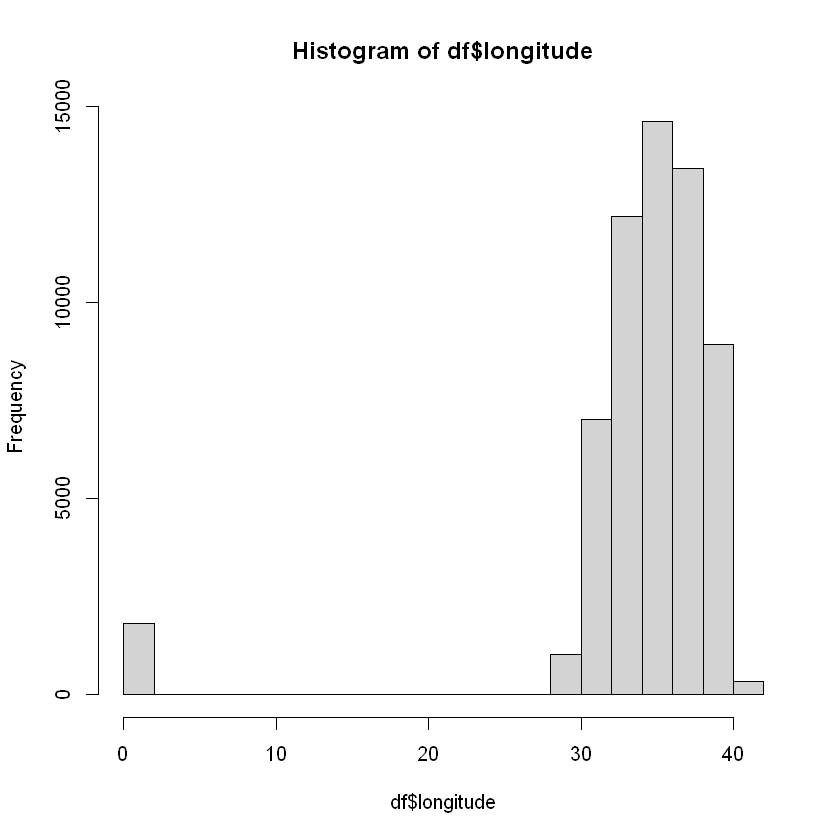

[1] 0

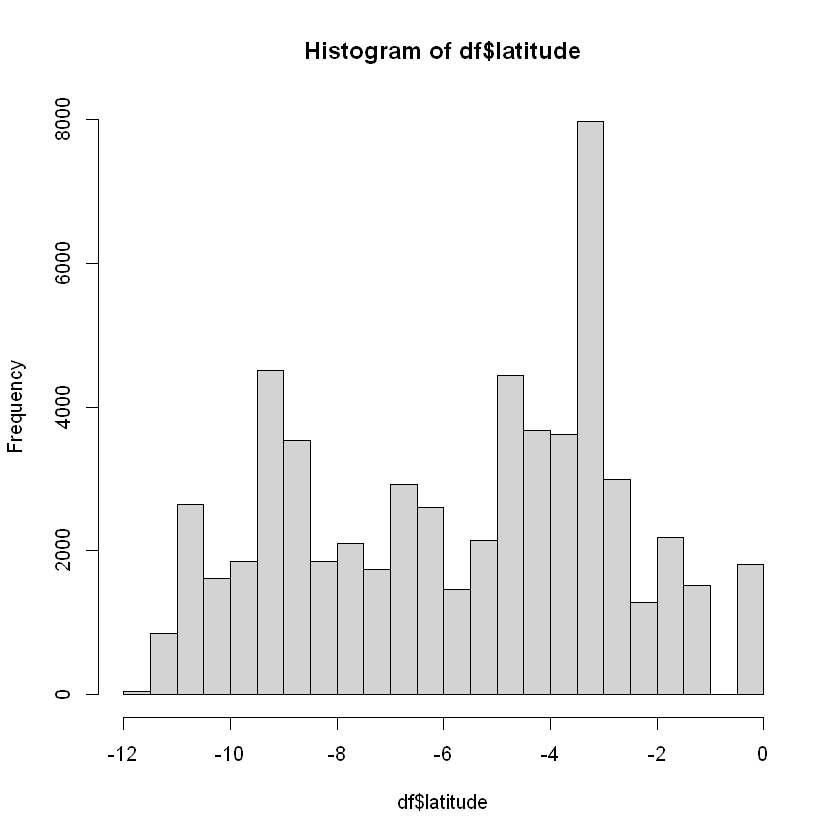

[1] 20438

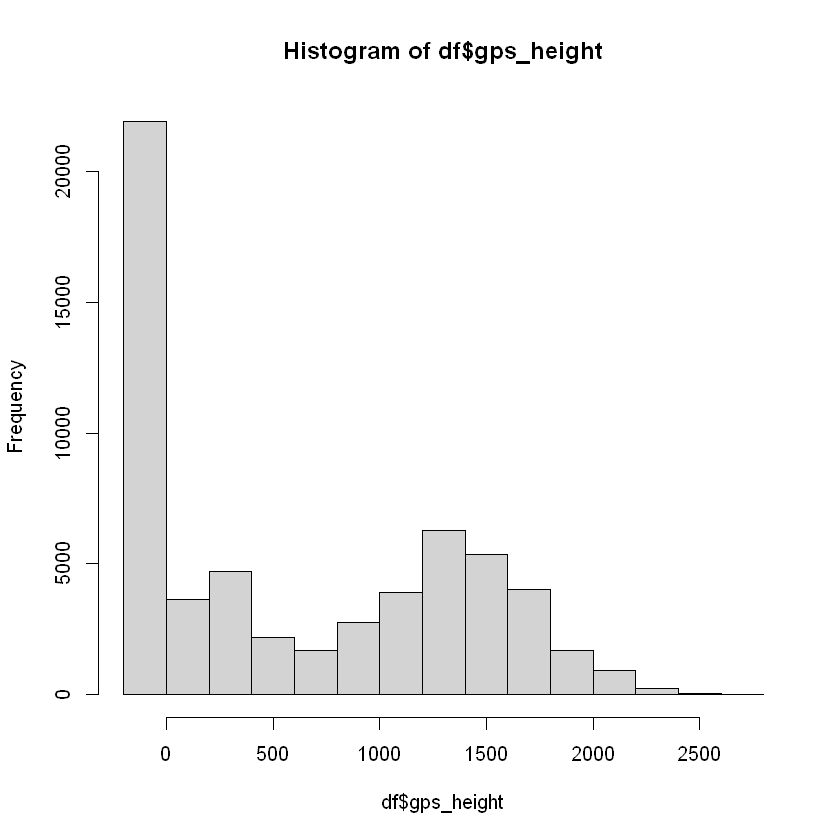

In [34]:
hist(df$longitude)
sum(df$longitude==0)/nrow(df)
hist(df$latitude)
sum(df$latitude==0)
hist(df$gps_height)
sum(df$gps_height==0)
# df <- df %>% filter(df$longitude!=0)

The variables *population* and *amount_tsh* also seem to have been badly measured. 36% of observations have a population equal to 0, and an additional 12% have a population equal to 1. Both values could be correct. But water pumps should not be too far from people benefiting from it, and as such we would have expected such values to be less frequent. Also, the relative weight of these values is in stark contrast with the rest of the distribution of the *population* variable. About 70% of the *amount_tsh* variable is equal to 0, meaning that there was no water available to waterpoint. This figure is puzzling given that more than half of the pump are qualified as functional, we would expect indeed that some water needs to be available at the water point for the pump to be tried and ultimately assessed as functional. A closer inspection of the distribution of non-zero values further illustrate how irregular this variable is. 

[1] 0.3599495

[1] 0.118266

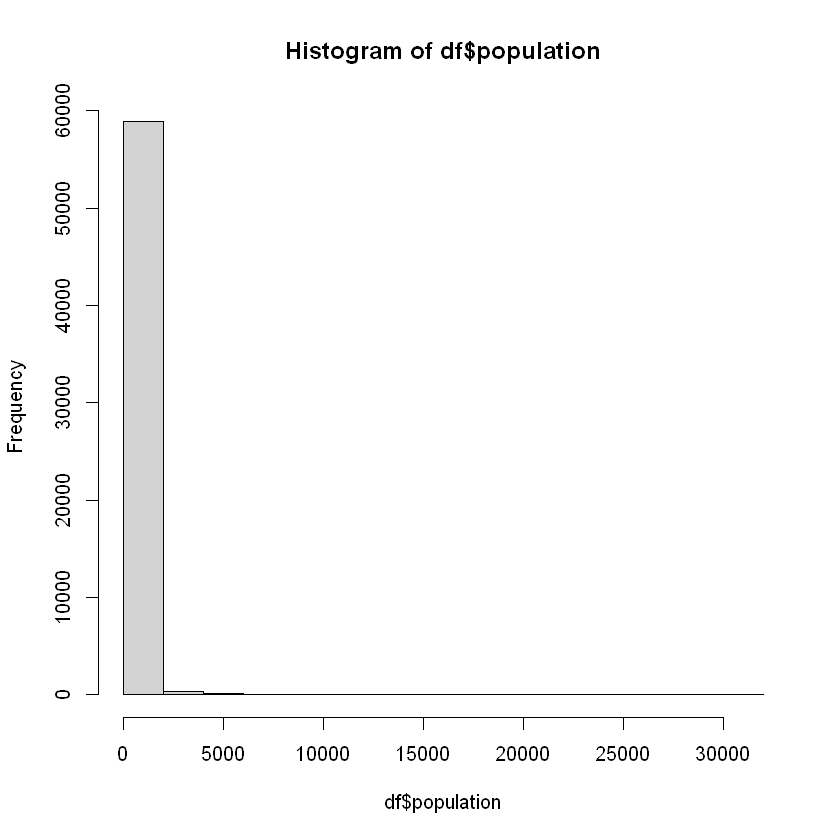

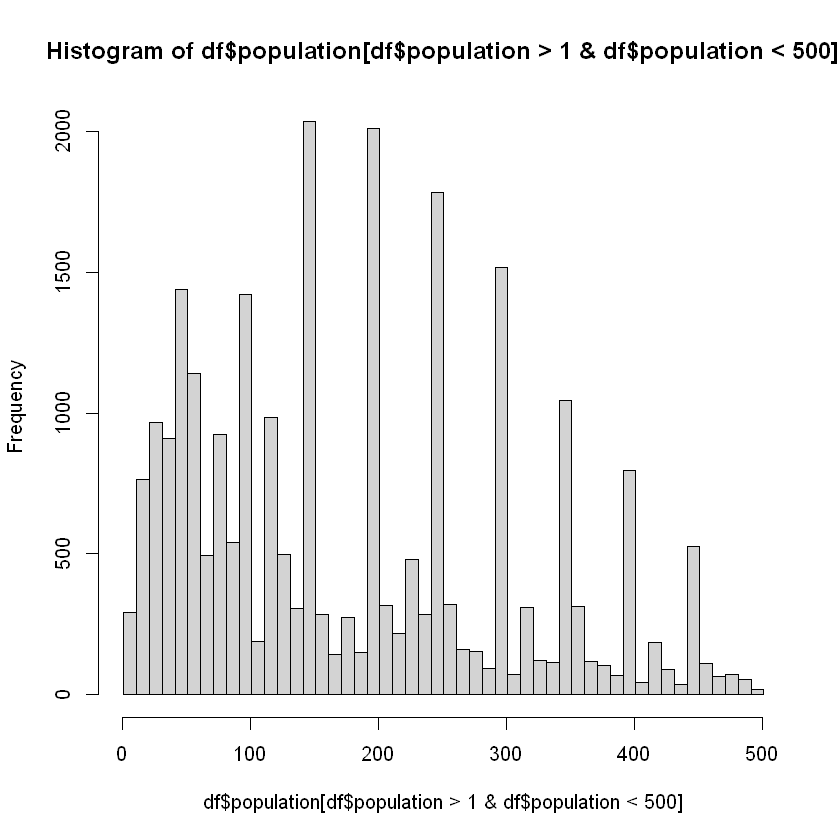

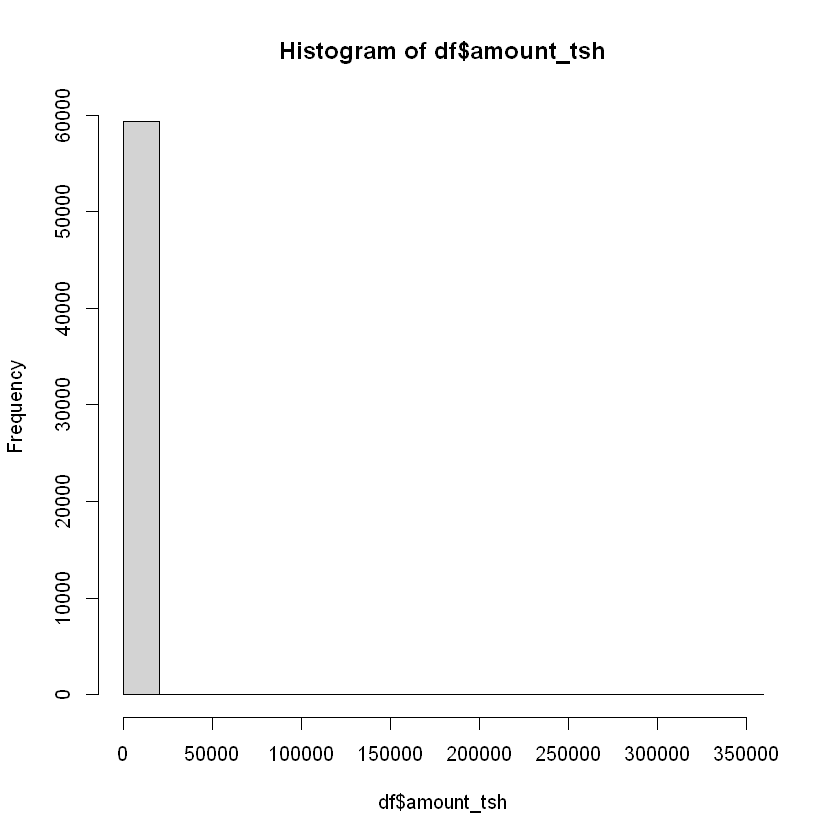

[1] 0.7009933


             functional functional needs repair          non functional 
                  32259                    4317                   22824 

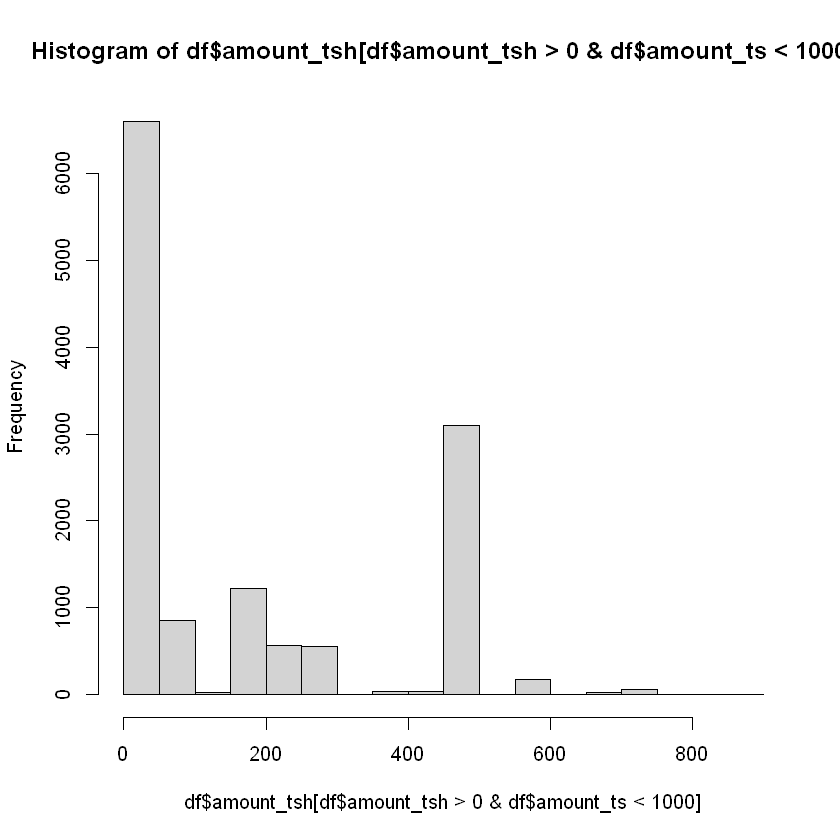

In [35]:
sum(df$population==0)/nrow(df)
sum(df$population==1)/nrow(df)
hist(df$population)
hist(df$population[df$population>1 & df$population <500], breaks = seq(from=1, to=501, by=10))
hist(df$amount_tsh)
hist(df$amount_tsh[df$amount_tsh>0 & df$amount_ts <1000])
sum(df$amount_tsh==0)/nrow(df)
table(df$status_group)

The data set contains two information about time: one about the year when the pump was constructed (*construction_year*), the other about the exact date when the pump was tested (*date_recorded*). *construction_year* equals zero for about 35% of the observation. This is obviously a measurement error. We set these observations to the median. *date_recorded* could be used as a factor variable with 356 different values and capturing daily fixed effect. However given that this contributes to considerably increase dimensions of the problem and therefore computing-time for several machine learning procedures, we decide to exploit information from this variable differently. First we transform it into a number to capture time trained at daily rate. We delete 31 observations with strictly implausible values. Then we create 3 categorical variables capturing the year, month and day of the week, during which the measure was taken. Finally we generate the variable *age* equal to the difference between the year of the observation and the construction year.

[1] 0.3486364

df$construction_year[df$construction_year != 0] 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   38691        0       54    0.998     1997    13.87     1973     1978 
     .25      .50      .75      .90      .95 
    1987     2000     2008     2010     2011 

lowest : 1960 1961 1962 1963 1964, highest: 2009 2010 2011 2012 2013


11974 12424 12478 12483 12509 12513 12539 12570 12600 12631 12662 12753 14977 
    1     1     4     1     1     1     2     1     1     2     2    14    30 
14978 14982 15006 15007 15008 15009 15019 15020 15021 15022 15023 15024 15025 
   22    47     7    17    53    33    13    23    36    18   130   117   154 
15026 15027 15028 15029 15030 15031 15032 15033 15034 15035 15036 15037 15038 
  189   175   323   263   254   351   294   341   276   232   378   458   434 
15039 15040 15041 15042 15043 15044 15045 15046 15047 15048 15049 15050 15051 
  327   333   328   416   364   426   379   373   520   572   513   558   497 
15052 15053 15054 15055 15056 15057 15058 15059 15060 15061 15062 15063 15064 
  466   262   351   364   417   381   294   342   298   337   296   391   213 
15065 15066 15067 15068 15069 15070 15071 15072 15073 15074 15075 15076 15077 
  252   264   267   254   114   145   185   167   161   159   157   160   154 
15078 15079 15080 15081 15082 15083 15084 15085 150

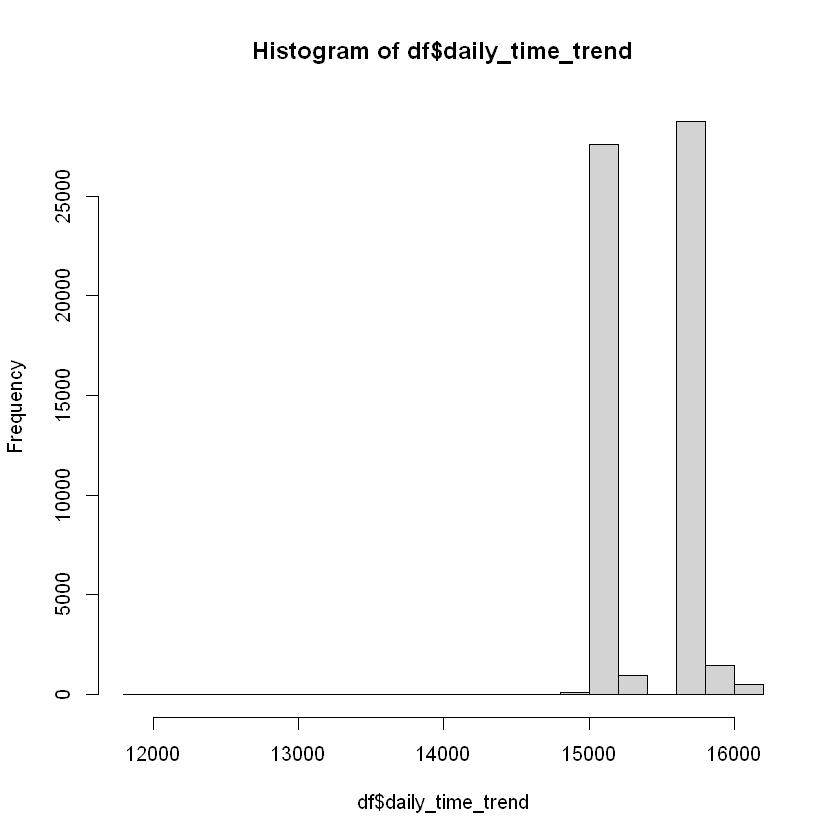

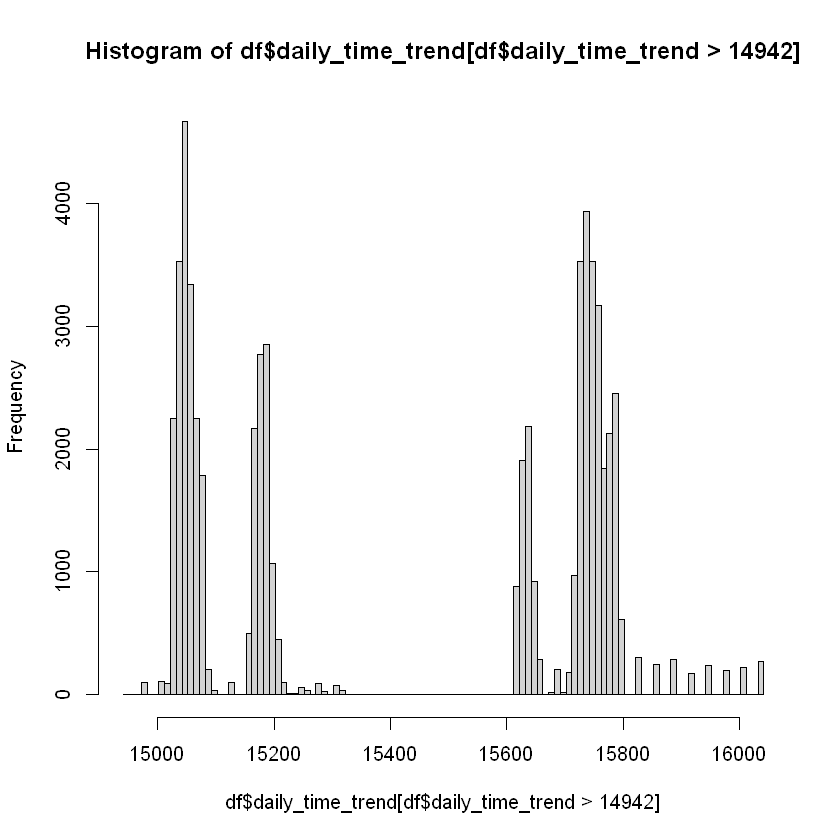

In [36]:
sum(df$construction_year==0)/nrow(df)
describe(df$construction_year[df$construction_year!=0])
df$construction_year[df$construction_year==0] <- 2000

df$m_date <- as.Date(df$date_recorded)
df$daily_time_trend <- as.numeric(df$m_date) # remove the too early ones
hist(df$daily_time_trend)
table(df$daily_time_trend)
# df <- df %>% filter(df$daily_time_trend>=14977)
hist(df$daily_time_trend[df$daily_time_trend>14942], breaks = seq(from=14942, to=16042, by=10))

df$m_months <- as.factor(as.numeric(format(df$m_date,'%m')))
df$m_day <- as.factor(weekdays(df$m_date))

df$m_year <- as.numeric(format(df$m_date,'%Y'))
df$age <- df$m_year - df$construction_year 

df$age <- as.numeric(df$m_year) - df$construction_year 

The remaining the variables are all categorical. One subgroup provide information on the geographical location (*basin* *subvillage* *region* *region_code* *district_code* *lga* *ward*). The rest provide diverse information about the pump. The geographical variable can be divided into two groups depending on the number of different categories: few (*basin* *region* *region_code* *district_code* *lga* *ward*) or many (*subvillage* *ward*). We remove from our data set those with too many levels. 

In [37]:
table(df$basin)
table(df$region, df$region_code)
table(df$district_code)
table(df$region_code)
table(df$lga)
describe(df$ward)
describe(df$subvillage)
 df<- df[, !(colnames(df) %in% c("ward", "subvillage"))]


               Internal              Lake Nyasa              Lake Rukwa 
                   7785                    5085                    2454 
        Lake Tanganyika           Lake Victoria                 Pangani 
                   6432                   10248                    8940 
                 Rufiji Ruvuma / Southern Coast             Wami / Ruvu 
                   7976                    4493                    5987 

               
                   1    2    3    4    5    6    7    8    9   10   11   12
  Arusha           0 3024    0    0    0    0    0    0    0    0    0    0
  Dar es Salaam    0    0    0    0    0    0  805    0    0    0    0    0
  Dodoma        2201    0    0    0    0    0    0    0    0    0    0    0
  Iringa           0    0    0    0    0    0    0    0    0    0 5294    0
  Kagera           0    0    0    0    0    0    0    0    0    0    0    0
  Kigoma           0    0    0    0    0    0    0    0    0    0    0    0
  Kilimanjaro      0    0 4379    0    0    0    0    0    0    0    0    0
  Lindi            0    0    0    0    0    0    0  300    0    0    0    0
  Manyara          0    0    0    0    0    0    0    0    0    0    0    0
  Mara             0    0    0    0    0    0    0    0    0    0    0    0
  Mbeya            0    0    0    0    0    0    0    0    0    0    0 4639
  Morogoro         0    0    0    0 4006    0    0    0    0    0    0  


    0     1     2     3     4     5     6     7     8    13    23    30    33 
   23 12203 11173  9998  8999  4356  4074  3343  1043   391   293   995   874 
   43    53    60    62    63    67    80 
  505   745    63   109   195     6    12 


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2201 3024 4379 2513 4040 1609  805  300  390 2640 5300 4639 2093 1979 1808 2816 
  17   18   19   20   21   24   40   60   80   90   99 
5011 3324 3047 1969 1583  326    1 1025 1238  917  423 


    Arusha Rural     Arusha Urban           Babati         Bagamoyo 
            1252               63              511              997 
            Bahi          Bariadi       Biharamulo     Bukoba Rural 
             224             1177              403              487 
    Bukoba Urban          Bukombe            Bunda         Chamwino 
              88              514              438              347 
           Chato           Chunya     Dodoma Urban            Geita 
             236              298              358              488 
             Hai           Hanang          Handeni           Igunga 
             625              274              254              338 
           Ilala            Ileje          Ilemela           Iramba 
             497              231              142              544 
    Iringa Rural           Kahama          Karagwe           Karatu 
             728              836              771              326 
          Kasulu           Kibaha

df$ward 
       n  missing distinct 
   59400        0     2092 

lowest : Aghondi      Akheri       Arash        Arri         Arusha Chini
highest: Ziwani       Zoissa       Zombo        Zongomera    Zuzu        

df$subvillage 
       n  missing distinct 
   59029      371    19287 

lowest : 'A' Kati          ##                1                 14Kambalage       18               
highest: Zumbawanu Shuleni Zunga             Zunguni           Zunzuli           Zuri             

Next comes the group of variable giving information about the pump with different levels of details (*extraction_type*  *extraction_type_group*  *extraction_type_class*  *management*  *management_group*  *payment*  *payment_type*  *water_quality*  *quality_group*  *quantity*  *quantity_group*  *source*  *source_type*  *source_class*  *waterpoint_type*  *waterpoint_type_group*). For instance *extraction_type* is strictly more precise than *extraction_type_group*, which is itself strictly more precise than *extraction_type_class*. As computational time varies a lot across machine learning algorithm depending on the number of features, we decide to keep both precise and general versions of these features, thus is allowing us to pick one or the other, depending on the model at use.

In [38]:
  table(df$extraction_type, df$extraction_type_group)
  table(df$extraction_type_group, df$extraction_type_class)
  table(df$management, df$management_group )
  table(df$payment,df$payment_type )
  table(df$water_quality,df$quality_group )
  table(df$quantity, df$quantity_group)
  table(df$source, df$source_type )
  table(df$source_type,df$source_class )
  table(df$waterpoint_type,df$waterpoint_type_group )

                           
                            afridev gravity india mark ii india mark iii  mono
  afridev                      1770       0             0              0     0
  cemo                            0       0             0              0     0
  climax                          0       0             0              0     0
  gravity                         0   26780             0              0     0
  india mark ii                   0       0          2400              0     0
  india mark iii                  0       0             0             98     0
  ksb                             0       0             0              0     0
  mono                            0       0             0              0  2865
  nira/tanira                     0       0             0              0     0
  other                           0       0             0              0     0
  other - mkulima/shinyanga       0       0             0              0     0
  other - play pump     

                 
                  gravity handpump motorpump other rope pump submersible
  afridev               0     1770         0     0         0           0
  gravity           26780        0         0     0         0           0
  india mark ii         0     2400         0     0         0           0
  india mark iii        0       98         0     0         0           0
  mono                  0        0      2865     0         0           0
  nira/tanira           0     8154         0     0         0           0
  other                 0        0         0  6430         0           0
  other handpump        0      364         0     0         0           0
  other motorpump       0        0       122     0         0           0
  rope pump             0        0         0     0       451           0
  submersible           0        0         0     0         0        6179
  swn 80                0     3670         0     0         0           0
  wind-powered          0        

                  
                   commercial other parastatal unknown user-group
  company                 685     0          0       0          0
  other                     0   844          0       0          0
  other - school            0    99          0       0          0
  parastatal                0     0       1768       0          0
  private operator       1971     0          0       0          0
  trust                    78     0          0       0          0
  unknown                   0     0          0     561          0
  vwc                       0     0          0       0      40507
  water authority         904     0          0       0          0
  water board               0     0          0       0       2933
  wua                       0     0          0       0       2535
  wug                       0     0          0       0       6515

                       
                        annually monthly never pay on failure other per bucket
  never pay                    0       0     25348          0     0          0
  other                        0       0         0          0  1054          0
  pay annually              3642       0         0          0     0          0
  pay monthly                  0    8300         0          0     0          0
  pay per bucket               0       0         0          0     0       8985
  pay when scheme fails        0       0         0       3914     0          0
  unknown                      0       0         0          0     0          0
                       
                        unknown
  never pay                   0
  other                       0
  pay annually                0
  pay monthly                 0
  pay per bucket              0
  pay when scheme fails       0
  unknown                  8157

                    
                     colored fluoride  good milky salty unknown
  coloured               490        0     0     0     0       0
  fluoride                 0      200     0     0     0       0
  fluoride abandoned       0       17     0     0     0       0
  milky                    0        0     0   804     0       0
  salty                    0        0     0     0  4856       0
  salty abandoned          0        0     0     0   339       0
  soft                     0        0 50818     0     0       0
  unknown                  0        0     0     0     0    1876

              
                 dry enough insufficient seasonal unknown
  dry           6246      0            0        0       0
  enough           0  33186            0        0       0
  insufficient     0      0        15129        0       0
  seasonal         0      0            0     4050       0
  unknown          0      0            0        0     789

                      
                       borehole   dam other rainwater harvesting river/lake
  dam                         0   656     0                    0          0
  hand dtw                  874     0     0                    0          0
  lake                        0     0     0                    0        765
  machine dbh             11075     0     0                    0          0
  other                       0     0   212                    0          0
  rainwater harvesting        0     0     0                 2295          0
  river                       0     0     0                    0       9612
  shallow well                0     0     0                    0          0
  spring                      0     0     0                    0          0
  unknown                     0     0    66                    0          0
                      
                       shallow well spring
  dam                             0      0
  hand dtw                      

                      
                       groundwater surface unknown
  borehole                   11949       0       0
  dam                            0     656       0
  other                          0       0     278
  rainwater harvesting           0    2295       0
  river/lake                     0   10377       0
  shallow well               16824       0       0
  spring                     17021       0       0

                             
                              cattle trough communal standpipe   dam hand pump
  cattle trough                         116                  0     0         0
  communal standpipe                      0              28522     0         0
  communal standpipe multiple             0               6103     0         0
  dam                                     0                  0     7         0
  hand pump                               0                  0     0     17488
  improved spring                         0                  0     0         0
  other                                   0                  0     0         0
                             
                              improved spring other
  cattle trough                             0     0
  communal standpipe                        0     0
  communal standpipe multiple               0     0
  dam                                       0     0
  hand pump                                 0   

*scheme_management*

*scheme_name*

*permit* 

*public_meeting* 

*funder*

*installer*

Finally we create a dummy variable equal to 1 whenever the *funder* is the same as the *installer*. 

In [39]:
df$installer <- tolower(df$installer)
df$funder <- tolower(df$funder)
df$funder_is_installer <- df$funder == df$installer & df$installer!=""
df$funder_is_installer[df$installer=="" | df$funder==""] <- "MISSING"
table(df$funder_is_installer)


  FALSE MISSING    TRUE 
  36762    3708   18930 

We apply all modification to the *test_value* dataset


In [40]:
test_values<- test_values[, !(colnames(test_values) %in% c("recorded_by", "num_private", "wpt_name"))]

# test_values <- test_values %>% filter(test_values$longitude!=0)
test_values$construction_year[test_values$construction_year==0] <- 2000
test_values$m_date <- as.Date(test_values$date_recorded)
test_values$daily_time_trend <- as.numeric(test_values$m_date) 
# test_values <- test_values %>% filter(test_values$daily_time_trend>=14977)

test_values$m_months <- as.factor(as.numeric(format(test_values$m_date,'%m')))
test_values$m_day <- as.factor(weekdays(test_values$m_date))

test_values$m_year <- as.numeric(format(test_values$m_date,'%Y'))
test_values$age <- test_values$m_year - test_values$construction_year 

test_values<- test_values[, !(colnames(test_values) %in% c("ward", "subvillage"))]

test_values$installer <- tolower(test_values$installer)
test_values$funder <- tolower(test_values$funder)
test_values$funder_is_installer <- test_values$funder == test_values$installer & test_values$installer!=""
test_values$funder_is_installer[test_values$installer=="" | test_values$funder==""] <- "MISSING"


# 2. Model selection

For this part we decided on 3 different learning methods: Decision trees using the package rpart, Support Vector Machine from e1071 and random forest from randomForest

For the learning method and model assessment we use cross-validation to choose the best performing learning methods, to see which method is less susceptible to bias and overfitting to the training dataset. This tells us less about which learning methods is best at predicting its own training dataset and more about how the models will perform in test datasets that are disconnected from its training.

This helps us identify which method works best to avoid overfitting the data to the training set so that we can maximise the score of the prediction of DataDriven's test set. For each method, the features are the same, all parameters are set to their default. We assume that this would be fair, as we could not afford spending an absurd amount of computational time hyperparameter tuning each method.

For each of the learning methods, we sample a subset of data for a sub-training dataset, and sample another subset for the testing datasets. We calculated the differences of predictions of the test set and averaged out the errors.

## Random Forest

In [44]:
# testing k-fold cross validation here
df$random <- runif(nrow(df), min=1, max=60000)
df$subset <-  ntile(df$random, 10)

library(randomForest)

rf_model_1 <- function(some_number) {
    #sampling subsets for training and testing dfs
  df_train <- train %>% filter(train$subset == some_number)
  df_test <- train %>% filter(train$subset != some_number)

  model_forest <- randomForest(as.factor(status_group) ~ 
                               + gps_height
                              + longitude + latitude
                              + extraction_type_group + quantity + source , 
                               data = df_train,)
  
  df_test$y_pred <- predict(model_forest, df_test)
  error <- sum(df_test$y_pred!=df_test$status_group)/nrow(df_test)
  
  results <- list("df_test" = df_test , "model_forest" = model_forest, "error" = error)
  
  return(c(results, model_forest))
}

allerrors=c()

list_results <- lapply(1:10, rf_model_1) #Generate data


for (i in 1:10){
  allerrors <- c(allerrors, list_results[[i]][3]$error)
}
print("Average random forest error rate")
print(mean(allerrors))



[1] "Average random forest error rate"
[1] 0.2655481


## Decision Trees

In [45]:
library(rpart)
df$random <- runif(nrow(df), min=1, max=60000)
df$subset <-  ntile(df$random, 10)

tr_model_1 <- function(some_number) {
  df_train <- train %>% filter(train$subset == some_number)
  df_test <- train %>% filter(train$subset != some_number)
  
  model_rpart <- rpart(as.factor(status_group) ~ 
                                + gps_height
                              + longitude + latitude + management
                              + extraction_type_group + quantity + source, 
                              data = df_train)
                              
  
  df_test$y_pred <- predict(model_rpart, df_test, type = "class")
  
  
  error <- sum(df_test$y_pred!=df_test$status_group)/nrow(df_test)
  
  results <- list("df_test" = df_test , "model_rpart" = model_rpart, "error" = error)
  
  return(results)
}

list_results <- lapply(1:10, tr_model_1) #Generate data

allerrors=c()
for (i in 1:10){
  allerrors <- c(allerrors, list_results[[i]][3]$error)
}

print("Average decision tree error rate")
print(mean(allerrors))

[1] "Average decision tree error rate"
[1] 0.3032267


## Support Vector Machine

In [46]:
library(e1071)
df$random <- runif(nrow(df), min=1, max=60000)
df$subset <-  ntile(df$random, 10)

svm_model_1 <- function(some_number) {
  df_train <- train %>% filter(train$subset == some_number)
  df_test <- train %>% filter(train$subset != some_number)
  
  model_svm <- svm(as.factor(status_group) ~ 
                                + gps_height
                              + longitude + latitude
                              + extraction_type_group + quantity + source, 
                              data = df_train)
                              

  
  df_test$y_pred <- predict(model_svm, df_test, type = "class")
  
  
  error <- sum(df_test$y_pred!=df_test$status_group)/nrow(df_test)
  
  results <- list("df_test" = df_test , "model_svm" = model_svm, "error" = error)
  
  return(results)
}

list_results <- lapply(1:10, svm_model_1) #Generate data

allerrors=c()
for (i in 1:10){
  allerrors <- c(allerrors, list_results[[i]][3]$error)
}
print("Average SVM error rate")
print(mean(allerrors))

[1] "Average SVM error rate"
[1] 0.3052563


Based on these results we found that on average, models derived from the randomForest approach seem to be performing the best, it is the learning method that's the least prone to overfitting.

We will further validate the model by using the model made from the dataset to predict its own training model, see how well it performs.

In [22]:
model_forest <- randomForest(as.factor(status_group) ~ 
                               + gps_height + amount_tsh
                               + longitude + latitude
                               + water_quality + quantity
                               + construction_year + district_code
                                + installer + population + scheme_management + source,
                               data = df, importance=TRUE,
                               ntree = 82, nodesize = 5)

# predict training set with own model
forest_pred_train <- predict(model_forest, train)
frerror <- sum(forest_pred_train!=df$status_group)/nrow(df)
print(frerror)

[1] 0.1129125


As we can see, it's pretty good at predicting its own training dataset, with an accuracy of around 90%. However, the problem with this is that we can always keep increasing this accuracy by removing features that decrease accuracy(low MeanDecreaseAccuracy):

In [23]:
# get model statistics
importance(model_forest)

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
gps_height,27.97218,21.10429,26.07223,34.80126,2154.8111
amount_tsh,30.58834,26.74391,26.87385,37.72150,1330.7654
longitude,39.94428,34.05125,47.98537,54.26528,3747.7618
latitude,47.87169,29.00456,44.13451,57.32701,3527.7995
water_quality,22.46143,13.86459,18.82150,25.33947,591.4779
quantity,79.98423,29.18583,99.78623,99.04337,4202.4287
construction_year,35.70591,24.65454,26.69456,43.74684,1967.6396
district_code,36.93801,29.18679,30.91725,45.95576,979.7754
installer,44.22148,24.37741,43.36441,55.75631,1514.8618
population,19.73778,11.03838,14.78522,21.17264,1487.5044


Doing this excessively will undoubtedly increases the accuracy and improve the model's ability to predict the training dataset, however, we will hit a point where our average prediction accuracy of the test set decreases. This is an overfitting issue, this is why we intentionally tried to not let the feature statistic importance influence too much to our feature selection process. This is the same reasoning why we chose our learning procedure using Cross Validation errors.

### Hyperparameter Tuning

To further improve our randomForest model we will perform some hyperparameter tuning, specifically ntree and nodesize. Using the same cross-validation method to compare the models.

Note: The code below has been disabled with # as it takes around 2 hours to complete.

In [3]:
tree_tuner <- function(some_number) {
  df_train <- train %>% filter(train$subset == some_number)
  df_test <- train %>% filter(train$subset != some_number)
  best_score<- 1
  for (i in 1:100){
  model_forest <- randomForest(as.factor(status_group) ~ 
                               + gps_height  + date_recorded
                               + longitude + latitude + management
                               + extraction_type_group
                               + water_quality + quantity + source
                               + waterpoint_type , 
                               data = df_train,
                               ntree = i, nodesize = 2)
  if (sum(predict(model_forest, df_test)!=df_test$status_group)/nrow(df_test)<best_score){
    best_score <- sum(predict(model_forest, df_test)!=df_test$status_group)/nrow(df_test)
    best_para <- i
  }}
  return(best_para)
}

node_tuner <- function(some_number) {
  df_train <- train %>% filter(train$subset == some_number)
  df_test <- train %>% filter(train$subset != some_number)
  best_score<- 1
  for (i in 1:10){
    model_forest <- randomForest(as.factor(status_group) ~ 
                                   + gps_height  + date_recorded
                                 + longitude + latitude + management
                                 + extraction_type_group
                                 + water_quality + quantity + source
                                 + waterpoint_type , 
                                 data = df_train,
                                 ntree = 80, nodesize = i)
    if (sum(predict(model_forest, df_test)!=df_test$status_group)/nrow(df_test)<best_score){
      best_score <- sum(predict(model_forest, df_test)!=df_test$status_group)/nrow(df_test)
      best_para <- i
    }}
  return(best_para)
}

#list_ntree <- c()
#for (x in 1:6){
  #curlist<- lapply(1:10, tree_tuner)
  #list_ntree <- c(list_ntree, curlist)
#}

#list_node<- c()
#for (x in 1:6){
  #curlist<- lapply(1:10, tree_tuner)
  #list_node <- c(list_node, curlist)
#}


For this process we applied the same cross-validation technique earlier, for each sub-sample, we run the model and assess it 100 times varying the ntree param from 1-100, each sub-sample(for which there're 10), we obtain 1 best-performing n-tree parameter, and we do this for 6 trials which gives us 60 values of best n-tree parameters. For node-size we also obtained 60 values however, we vary the parameter from 1-10.

#### Top-performing ntree values

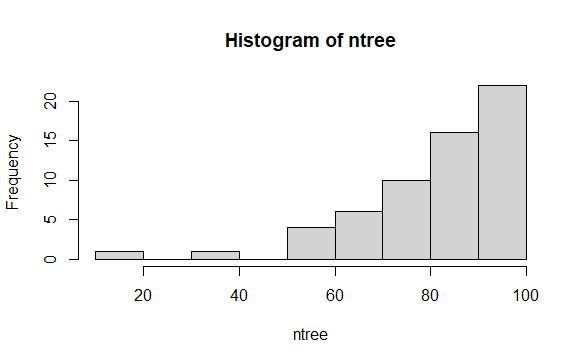

In [7]:
#>summary(ntree)
#  Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
# 19.00   73.00   85.50   82.18   95.25  100.00 

#### Top-performing nodesize values


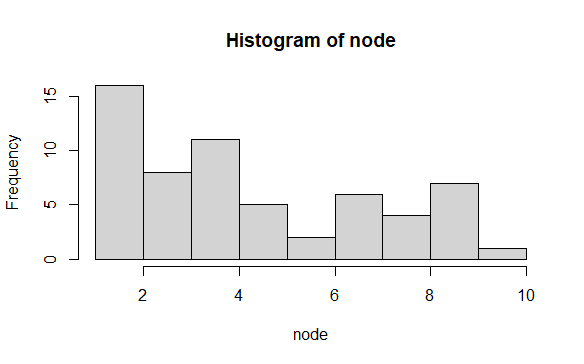


In [9]:
#>summary(node)
#  Min. 1st Qu.  Median    Mean 3rd Qu.    Max.   
#  1.000   2.000   4.000   4.633   7.000  10.000 

From the mean values we determined the best ntree parameter to be 82, and the best nodesize to be 5. 

### Revisiting feature selection

We also revisited the feature selection section. Using Cross-Validation(CV) we "played around" with the feature set and see how they would improve our CV accuracy. Due to the randomness of randomForest, the change in accuracy after removing or adding features to the set is not always apparent, as such this was a long and time-consuming section, as well as being rather vague, some features had a consistent improvement while others seem to not change or slightly decrease the accuracy. We did this section somewhat manually, as we wanted our feature set to also make sense intuitively. As well as the fact that we decided against evaluating each feature alone and picking the best performers, as some features have synergy together(having both increases the accuracy) and some other combinations have antagonistic behavior(having both decreases the accuracy)

Below you can find the code that we used, this would normally in another loop and we would do this 6-10 times and average out the averages. This code is very similar to the ones we used, to vary the features we manually added and subtracted from the function.

In [47]:
# testing k-fold cross validation here
df$random <- runif(nrow(df), min=1, max=60000)
df$subset <-  ntile(df$random, 10)

library(randomForest)

rf_model_1 <- function(some_number) {
  #sampling subsets for training and testing dfs
  df_train <- df %>% filter(df$subset == some_number)
  df_test <- df %>% filter(df$subset != some_number)
  
  model_forest <- randomForest(as.factor(status_group) ~ 
                                 + amount_tsh + gps_height 
                                + longitude + latitude
                               + lga + population + construction_year
                               + management + extraction_type
                               + quality_group + quantity + source
                               + waterpoint_type+ m_year + payment, 
                               data = df_train,
                               ntree = 82, nodesize = 5)
  
  df_test$y_pred <- predict(model_forest, df_test)
  error <- sum(df_test$y_pred!=df_test$status_group)/nrow(df_test)
  
  results <- list("df_test" = df_test , "model_forest" = model_forest, "error" = error)
  
  return(c(results, model_forest))
}

allerrors=c()

list_results <- lapply(1:10, rf_model_1) #Generate data


for (i in 1:10){
  allerrors <- c(allerrors, list_results[[i]][3]$error)
}
print("Average random forest error rate")
print(mean(allerrors))

[1] "Average random forest error rate"
[1] 0.2394444


For our final pick of model, we will use Random Forest on the whole dataset with the following features: *amount_tsh, gps_height, longitude, latitude, lga, population, construction_year, management, extraction_type, quality_group, quantity, source, waterpoint_type, m_year, payment.*

# 3. Alternate learning procedure

We chose here to implement a Gradient Boosting Tree. The Gradient Boosting Tree is a technique used to produce a prediction model with decisions tree. They are an ensemble of decision tree models, which mean that the gradient boosting tree is a set of decisions trees that perform the prediction together. The gradient boosting tree consist on the fact that each one of the tree will learn the difference from the prediction of the other previous tree and from the real value. Which mean that the final prediction will be the addition of the prediction from all the other trees. As the running time of the gradient boosting tree is very long we need to, as we did for the previous model, sample a subset of data for a sub-training dataset, and sample another subset for the testing datasets. We calculated the differences of predictions of the test set and averaged out the errors.

# 4. Final Drivendata Prediction

In [ ]:
# predicting test set with model
forest_pred_test <- predict(model_forest, test)

# create submission data frame
submission <- data.frame(test$id)
submission$status_group <- forest_pred_test
names(submission)[1] <- "id"

# printing submission to csv
write.csv(submission, file = "submission.csv", row.names = FALSE)


Due to the random nature of random Forest, we submitted 3 times. The scores we got are the following: